8.3544921875


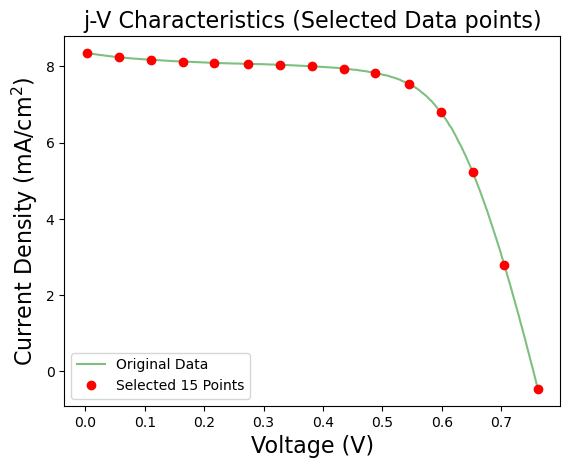

0.00244140625 8.3544921875
0.05615234375 8.2421875
0.10986328125 8.173828125000002
0.16357421875 8.128662109375
0.21728515625 8.092041015625
0.2734375 8.067626953125
0.3271484375 8.0419921875
0.380859375 8.0047607421875
0.4345703125 7.9443359375
0.48828125 7.82958984375
0.54443359375 7.54150390625
0.59814453125 6.80908203125
0.65185546875 5.23681640625
0.70556640625 2.779541015625
0.76171875 -0.46423339843750006


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

data = pd.read_excel('23SA11.xlsx')
vd = data['V'].to_numpy()
jd = data['J'].to_numpy()
jph=np.max(jd)
print(jph)
ir = IsotonicRegression(increasing=False)
jd_s = ir.fit_transform(vd, jd)  # Fit and transform
vd_s = vd  # Keep voltage values the same

num_points = 15
indices = np.linspace(0, len(vd_s) - 1, num=num_points, dtype=int)
vd_s = vd_s[indices]
jd_s = jd_s[indices]

plt.plot(vd, jd, color='green', alpha=0.5, label='Original Data')
plt.plot(vd_s, jd_s, 'o', label='Selected 15 Points', color='red')
plt.xlabel('Voltage (V)', fontsize='16')
plt.ylabel('Current Density (mA/cm$^2$)', fontsize='16')
plt.title('j-V Characteristics (Selected Data points)', fontsize='16')
plt.legend()
plt.show()
for i in range(len(vd_s)):
    print(vd_s[i], jd_s[i])

8.355095504073784
Rsh (ohm-cm^2) = 1353.880109084615
Rs (ohm-cm^2)= 15.836093113888582
m = 2.7225259712997
j0 (mA/cm^2)= 0.0006033165737839852


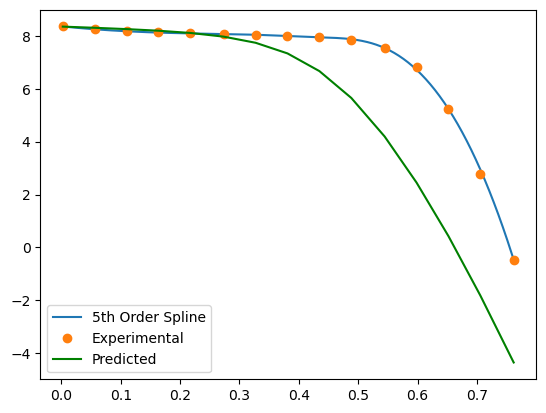

In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fsolve

k=2
v=vd_s[::k]
j=jd_s[::k]
m=len(v)-1

def diode_eq(jp, vd, j0, jph, Rs, Rsh, m):
    return jph - j0*(np.exp(q*(vd+jp*Rs)/(m*k*T)) - 1)-vd/Rsh-jp

qs = InterpolatedUnivariateSpline(v, j, k=3)
v_fine=np.linspace(min(v), max(v), 500)
j_fine=qs(v_fine)

#Fitting Cubic Polynomial
j_d_prime = qs.derivative(1)(v_fine)
j_d_double_prime = qs.derivative(2)(v_fine)
cubic_coeffs = np.polyfit(j_d_prime, j_d_double_prime, 3)
roots = np.roots(cubic_coeffs)
roots = np.sort(roots)

Rsh=-1 / np.real(roots[-1])
Rs=-1/np.mean(np.real(roots[:-1]))
ca3=cubic_coeffs[0]
f=ca3/Rs**2
g=f*Rs
b=-1/Rsh

numerator=j_d_prime-b
denominator=f+g*j_d_prime
dep_var=numerator/denominator
indep_var=j_fine-b*v_fine
a=-1*(dep_var-indep_var)
asort=np.sort(a)
jph=8.3544921875

for i in range(len(asort)):
    if(asort[i]>jph):
        print(asort[i])
        j0=asort[i]-jph
        break

m=38.91/f

q = 1.602e-19
k = 1.3806e-23
T = 298

jp = np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd_s])

print("Rsh (ohm-cm^2) =", Rsh*1000)
print("Rs (ohm-cm^2)=", Rs*1000)
print("m =", m)
print("j0 (mA/cm^2)=", j0)

plt.plot(v_fine, j_fine, label='5th Order Spline')
plt.plot(vd_s, jd_s, 'o', label='Experimental')
plt.plot(vd_s, jp, color='green', label='Predicted')
plt.legend()
plt.show()

j0= 9.561923306892036e-05


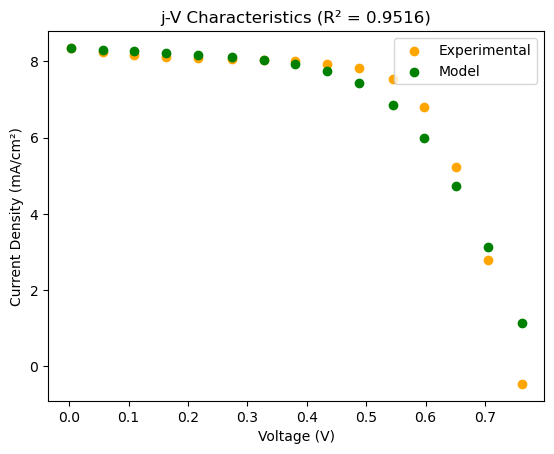

In [7]:
q = 1.602e-19
k = 1.3806e-23
T = 298

a=2
j0=6.033165737839852*10**(-1*a)
r2=-100
af=2
#print(jph, Rs, Rsh)
for i in range(200):
    a=a+0.1
    j0=6.033165737839852*10**(-1*a)
    jp = np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd_s])
    ss_res = np.sum((jd_s-jp) ** 2)
    ss_tot = np.sum((jd_s-np.mean(jd_s)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    #print(r_squared, a)
    if(r_squared>r2):
        af=a
        r2=r_squared
j0=6.033165737839852*10**(-1*af-0)
jp = np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd_s])
print("j0=", j0)
plt.scatter(vd_s, jd_s, label="Experimental", color='orange', linestyle='-')
plt.scatter(vd_s, jp, label="Model", color='green')
plt.xlabel("Voltage (V)")
plt.ylabel("Current Density (mA/cm²)")
plt.legend()
plt.title(f"j-V Characteristics (R² = {r2:.4f})")
plt.show()

[95.61923306892037, 0.01583609311388858, 1.353880109084615, 2.7225259712997]
15 15
Iteration 0: R² = 0.99621
[5.18809925e+01 1.59118780e-02 1.27477175e+00 2.60879095e+00]
15 15
Iteration 1: R² = 0.99502
[2.61476494e+01 1.60584402e-02 1.21737548e+00 2.49588931e+00]
15 15
Iteration 2: R² = 0.99292
[12.13873763  0.01628353  1.17560945  2.38483122]
15 15
Iteration 3: R² = 0.98973
[5.17147255 0.01659937 1.1455803  2.27701918]
15 15
Iteration 4: R² = 0.98553
[2.0491746  0.01702217 1.12459789 2.17468365]
15 15
Iteration 5: R² = 0.98100
[0.79666834 0.0175657  1.11056043 2.08134937]
15 15
Iteration 6: R² = 0.97741
[0.33553682 0.01822027 1.10151603 2.00133558]
15 15
Iteration 7: R² = 0.97546
[0.1649615  0.0189301  1.0955386  1.93668125]
15 15
Iteration 8: R² = 0.97476
[0.09347946 0.01962281 1.09109575 1.88474917]
15 15
Iteration 9: R² = 0.97471
[0.0581923  0.02025789 1.08732889 1.8412841 ]
15 15
Iteration 10: R² = 0.97498
[0.03839359 0.02082424 1.08385489 1.80324446]
15 15
Iteration 11: R² = 0.9

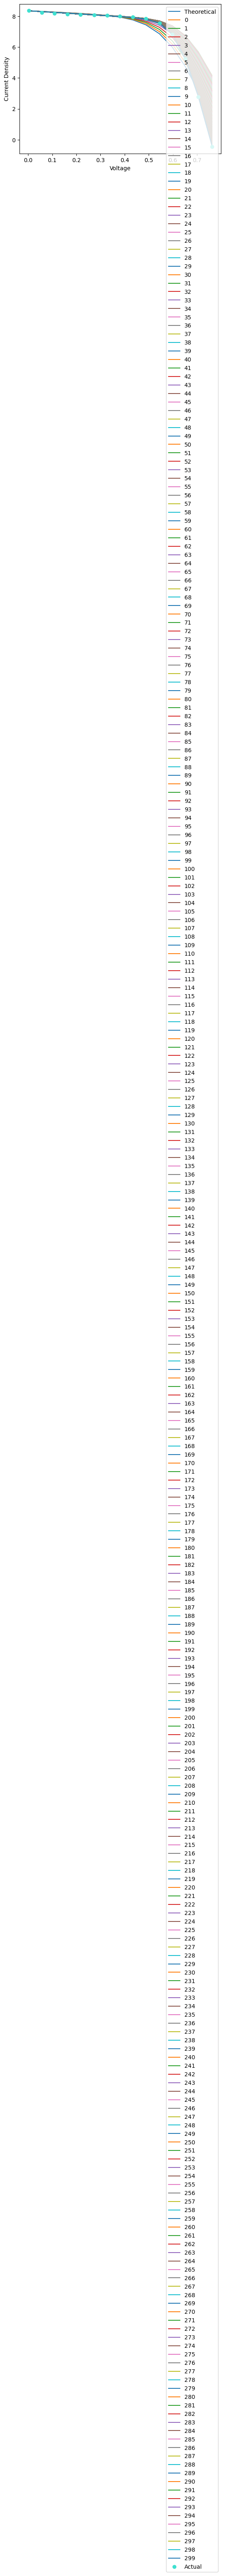

In [9]:
#Jacobian Correction
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

def diode_eq(jp, vd, j0, jph, Rs, Rsh, m):
    return jph - j0*(np.exp(q*(vd+jp*Rs)/(m*k*T)) - 1)-vd/Rsh-jp

def Jmat(jp, vd, k1, Rs, Rsh, m):
    J=[0, 0, 0, 0]
    print(jp.size, vd.size)
    J[0]=-10**(-6)*(np.exp(q/(m*k*T)*(vd+Rs*jp))-1)
    J[1]=-k1*10**(-6)*np.exp(q/(m*k*T)*(vd+Rs*jp))*(q*jp/(m*k*T))
    J[2]=vd/(Rsh**2)
    J[3]=k1*10**(-6)*np.exp(q/(m*k*T)*(vd+Rs*jp))*(q/(m*m*k*T)*(vd+Rs*jp))
    return J

#The initial Values
k1=95.61923306892036
Rs=0.015836093113888582
Rsh=1.353880109084615
m=2.7225259712997

#Residual Computation
jp=np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd_s])
R=jd_s-jp
P=[k1, Rs, Rsh, m]
plt.plot(vd_s, jp, label='Theoretical')
for i in range(300):
    print(P)
    J=Jmat(jp, vd_s, k1, Rs, Rsh, m)
    J1=np.dot(J, np.transpose(J))
    delP=-1*np.dot(np.linalg.inv(J1), np.dot(J, R))
    alpha=0.06
    P=P-alpha*delP
    k1=P[0]
    Rs=P[1]
    Rsh=P[2]
    m=P[3]
    j0=k1*10**(-6)
    jp = np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd_s])
    plt.plot(vd_s, jp, label=i)
    R=jd_s-jp
    R2 = 1 - np.sum(R**2) / np.sum((jd - np.mean(jd))**2)
    print(f"Iteration {i}: R² = {R2:.5f}")
print("j0=", j0)
print("Rs=", Rs)
print("Rsh=", Rsh)
print("m=", m)
plt.plot(vd_s, jd_s, 'o', label='Actual', color='turquoise')
#plt.plot(vd, jp, label='Theoretical')
plt.xlabel('Voltage')
plt.ylabel('Current Density')
plt.legend()
plt.show()

8.3544921875


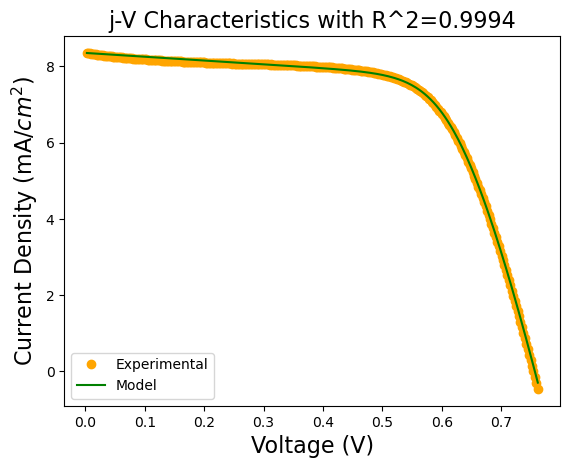

R$^2$: 0.999421203805497


In [13]:
#Final Plot using Parameters Obtained
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from matplotlib import pyplot as plt

def diode_eq(jp, vd, j0, jph, Rs, Rsh, m):
    return jph - j0*(np.exp(q*(vd+jp*Rs)/(m*k*T)) - 1)-vd/Rsh-jp

#Knowns:
q=1.6*10**(-19)
k=1.38*10**(-23)
T=298

#Parameters Obtained
j0=4.614598906686525e-09
Rs=0.012253430391363089
Rsh=1.0082949744746916
m=1.3872368326558604

print(jph)
data=pd.read_excel('23SA11.xlsx')
vd=data['V']
jd=data['J']

jp=np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd])

plt.plot(vd, jd, 'o', label='Experimental', color='orange')
plt.plot(vd, jp, label='Model', color='green')
plt.xlabel('Voltage (V)', fontsize='16')
plt.ylabel('Current Density (mA/$cm^2$)', fontsize='16')
plt.title('j-V Characteristics with R^2=0.9994', fontsize='16')
plt.legend()
plt.show()

#Goodness of the Plot
jd_mean = np.mean(jd)
ss_total = np.sum((jd - jd_mean) ** 2)
ss_residual = np.sum((jd - jp) ** 2)
r2 = 1 - (ss_residual / ss_total)
print("R$^2$:", r2)